In [3]:
!pip install caer canaro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 14.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 89.6 MB/s eta 0:00:00:00:0100:01


In [4]:
import os 
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

Before we feed the images to the network the images should be in same size.

In [5]:
img_size = (80,80)
channels = 1
char_path = r'/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset'

Grabing the first 10 image sets into a dictionary which are in decending order.

In [6]:
char_dict = {}
# Add error handling to be safe
if os.path.isdir(char_path):
    for char in os.listdir(char_path):
        char_folder = os.path.join(char_path, char)
        if os.path.isdir(char_folder):  # Check if it's actually a directory
            char_dict[char] = len(os.listdir(char_folder))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [7]:
#grabing first 10 names in the dictionary
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >=10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [8]:
#create the training data
#here this code will go inside the simpson dataset and go inside the every character folder and grab the images from the first 10 folders and put tem in train dataset
train = caer.preprocess_from_dir(char_path, characters, channels= channels, IMG_SIZE = img_size, isShuffle = True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 3.8915421962738037s
[INFO] At 1000 files
[INFO] 1454 files found in 3.1106293201446533s
[INFO] At 1000 files
[INFO] 1452 files found in 3.357541799545288s
[INFO] At 1000 files
[INFO] 1354 files found in 2.797908306121826s
[INFO] At 1000 files
[INFO] 1342 files found in 2.994166135787964s
[INFO] At 1000 files
[INFO] 1291 files found in 2.956564426422119s
[INFO] At 1000 files
[INFO] 1206 files found in 3.258132219314575s
[INFO] At 1000 files
[INFO] 1194 files found in 3.1622426509857178s
[INFO] At 1000 files
[INFO] 1193 files found in 2.798762798309326s
[INFO] At 1000 files
[INFO] 1079 files found in 2.6759140491485596s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 2m 30s


In [9]:
len(train)

13811

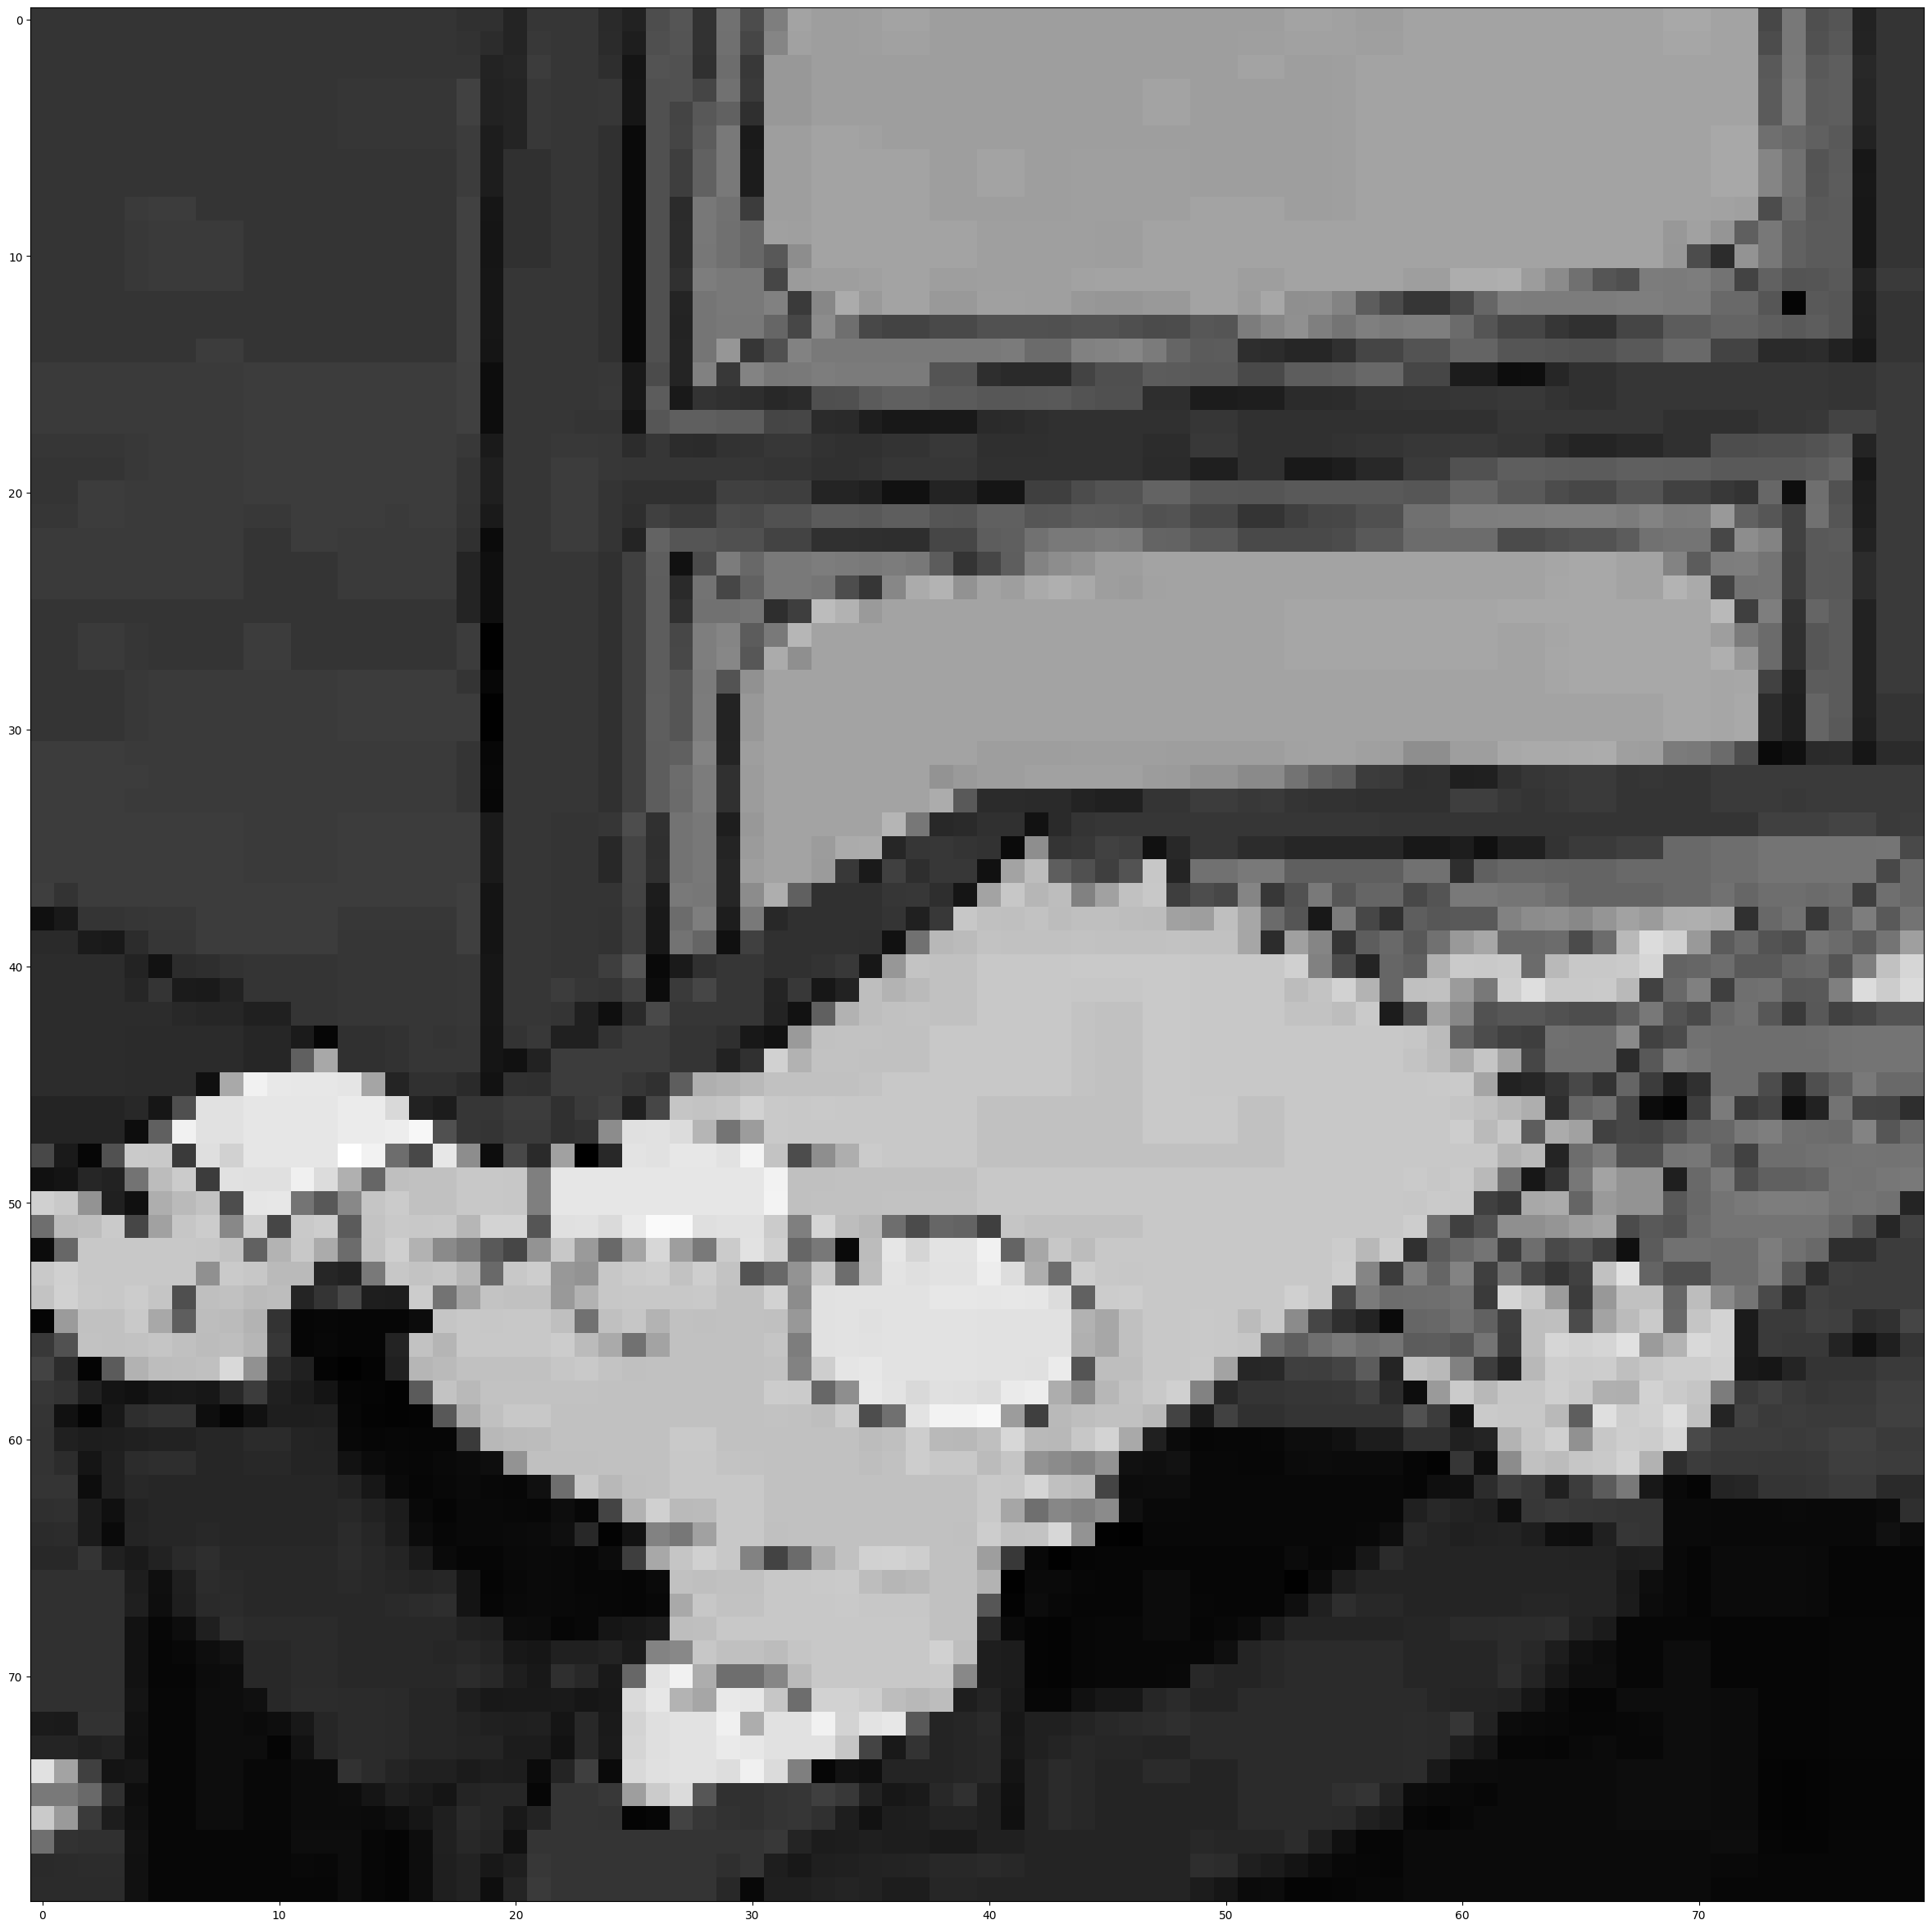

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0],cmap='gray')
plt.show()

In [11]:
featureSet, labels = caer.sep_train(train, IMG_SIZE = img_size)

In [12]:
#normalize the feature set --> (0,1)
from tensorflow.keras.utils import to_categorical
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [13]:
#its nothing but spliting the data into training and testing.
X_train , X_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [14]:
del train
del featureSet
del labels
gc.collect()

0

In [15]:
BATCH_SIZE = 32
EPOCHS = 10

In [16]:
#image data generator
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)

In [17]:
# Create our model (returns a compiled model)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

output_dim=10

w, h = img_size[:2]

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(w, h,channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))

# Output Layer
model.add(Dense(output_dim, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 80, 80, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 78, 78, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 39, 39, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 39, 39, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 39, 39, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 18, 18, 256)         │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      16,778,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,591,274 (67.11 MB)

 Trainable params: 17,591,274 (67.11 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.optimizers import SGD  # Import from main optimizers, not legacy

# Create the optimizer with current syntax
optimizer = SGD(
    learning_rate=0.001,
    weight_decay=1e-7,  # 'decay' is now 'weight_decay' in Keras 3
    momentum=0.9,
    nesterov=True
)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [20]:
# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


345/345 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.1443 - loss: 0.3920 - val_accuracy: 0.1643 - val_loss: 0.3331 - learning_rate: 0.0100
Epoch 2/10
  1/345 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.0625 - loss: 0.3274

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0625 - loss: 0.3274 - val_accuracy: 0.1643 - val_loss: 0.3333 - learning_rate: 0.0100
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.1580 - loss: 0.3235 - val_accuracy: 0.1643 - val_loss: 0.3327 - learning_rate: 0.0100
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0312 - loss: 0.3280 - val_accuracy: 0.1643 - val_loss: 0.3329 - learning_rate: 0.0100
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.1619 - loss: 0.3231 - val_accuracy: 0.1643 - val_loss: 0.3325 - learning_rate: 0.0100
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0938 - loss: 0.3316 - val_accuracy: 0.1643 - val_loss: 0.3331 - learning_rate: 0.0100
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.1611 - loss: 0.3226 - val_accuracy: 0.1776 - val_loss: 0.3305 - learning_rate: 0.0100
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1250 - loss: 0.3252 - val_accu

In [21]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

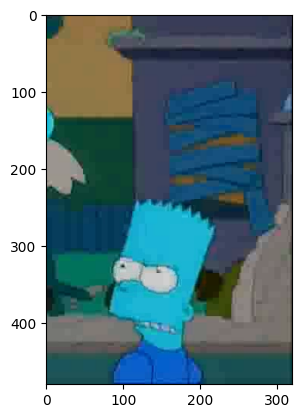

In [48]:
import cv2 as cv
test_path = r'/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/bart_simpson/pic_0002.jpg'
img = cv.imread(test_path)
# Convert BGR to RGB for matplotlib
plt.imshow(img)
plt.show()

In [49]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, img_size)
    image = caer.reshape(image, img_size, 1)
    return image

In [50]:
predictions = model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [51]:
predictions

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [52]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])

homer_simpson
